In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor

Almost the same as generate-data-and-fit.ipynb but uses tree instead of ANN.

# Generate data

In [2]:
from read_results import read_varnames
import small_strato_f90.kpp4py as kpp4py

In [3]:
nvar = 5
varnames = read_varnames("small_strato_F90/small_strato_Parameters.f90")[0:nvar]
print(varnames)

['O1D', 'O', 'O3', 'NO', 'NO2']


In [4]:
df_range = (
    pd.read_csv('small_strato_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
O1D,1.000000e-08,1.550810e+02,7.754051e+01,1.550810e+02
O,1.000000e-08,1.040641e+09,5.203203e+08,1.040641e+09
O3,5.377002e+11,8.486620e+11,6.931811e+11,3.109618e+11
NO,1.000000e-08,9.433271e+08,4.716635e+08,9.433271e+08
NO2,1.531729e+08,1.096500e+09,6.248365e+08,9.433271e+08
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


In [5]:
shrink = 0.0

y0_list =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(5000, nvar+1))
y0_list.shape

(5000, 6)

In [6]:
%time y1_list = kpp4py.onestep(y0_list.T).T
y1_list.shape

CPU times: user 117 ms, sys: 1.54 ms, total: 119 ms
Wall time: 121 ms


(5000, 5)

# Normalize data

Not neccessary, just for better comparison with ANN

In [7]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:5])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
X_train = np.append(normalizer.transform(y0_list[:,0:5]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 6)

In [9]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([0.87244568, 0.86418803, 0.99352065, 1.25022875, 1.01682482])

# Fit tree

In [10]:
# dtr = DecisionTreeRegressor(max_depth=10) # very bad
# dtr = RandomForestRegressor(max_depth=10) # no too much better than single tree
# dtr = ExtraTreesRegressor() # not too different from RF

# Gradient boosting performs the best here, but still not good enough compared to ANN
# it is also quite slow...
dtr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=50, learning_rate=0.5)) 

In [11]:
%%time
dtr.fit(X_train, Y_train)

CPU times: user 737 ms, sys: 8.86 ms, total: 746 ms
Wall time: 753 ms


MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
           n_jobs=1)

In [12]:
%%time 
y_pred = dtr.predict(X_train)

CPU times: user 20.3 ms, sys: 1.21 ms, total: 21.5 ms
Wall time: 22.4 ms


In [13]:
r2_score(y_pred, Y_train, multioutput='raw_values')

array([0.99922069, 0.99914386, 0.99984887, 0.99448315, 0.99163843])

# Test set

In [14]:
shrink = 0.0

y0_test =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(20000, nvar+1))

In [15]:
%time y1_test = kpp4py.onestep(y0_test.T).T

CPU times: user 412 ms, sys: 5.12 ms, total: 417 ms
Wall time: 426 ms


In [16]:
X_test = np.append(normalizer.transform(y0_test[:,0:5]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [17]:
Y_test.shape

(20000, 5)

In [18]:
%%time
y_test_pred = dtr.predict(X_test)

CPU times: user 64.7 ms, sys: 2.15 ms, total: 66.9 ms
Wall time: 67.4 ms


In [19]:
r2_score(y_test_pred, Y_test, multioutput='raw_values')

array([0.99884344, 0.9986836 , 0.9998039 , 0.99151543, 0.98626707])

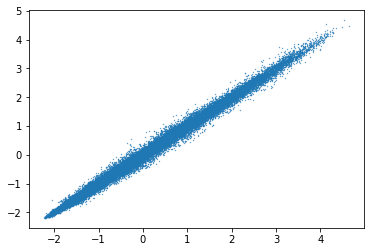

In [20]:
plt.scatter(y_test_pred, Y_test, s=0.1)